In [97]:
import tensorflow as tf
tf.__version__

'1.4.0'

### tf.keras imports

In [121]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Input, Dense, Activation
from tensorflow.python.keras.layers import Reshape, Lambda
from tensorflow.python.keras.layers import GRU
from tensorflow.python.keras.layers import add, concatenate
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.optimizers import SGD


### misc imports

In [122]:
import cv2
import os
import numpy as np
from os.path import join
import json
import random
import itertools
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [123]:
cv2.__version__

'3.1.0'

In [124]:
sess = tf.Session()

### get alphabet

In [125]:
from collections import Counter
def get_counter(dirpath):
    dirname = os.path.basename(dirpath)
    ann_dirpath = join(dirpath, 'ann')
    letters = ''
    lens = []
    for filename in os.listdir(ann_dirpath):
        json_filepath = join(ann_dirpath, filename)
        description = json.load(open(json_filepath, 'r'))['description']
        lens.append(len(description))
        letters += description
    print('Max plate length in "%s":' % dirname, max(Counter(lens).keys()))
    return Counter(letters)
c_val = get_counter('/home/martin/workspace/datasets/ocr-2213/val/anpr_ocr/train')
c_train = get_counter('/home/martin/workspace/datasets/ocr-2213/train/anpr_ocr/train')
letters_train = set(c_train.keys())
letters_val = set(c_val.keys())
if letters_train == letters_val:
    print('Letters in train and val do match')
else:
    raise Exception()
# print(len(letters_train), len(letters_val), len(letters_val | letters_train))
letters = sorted(list(letters_train))
print('Letters:', ' '.join(letters))

Max plate length in "train": 8
Max plate length in "train": 8
Letters in train and val do match
Letters: 0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y


# input generator

In [126]:
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

class TextImageGenerator:
    
    def __init__(self, 
                 dirpath, 
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=8):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = join(dirpath, 'img')
        ann_dirpath = join(dirpath, 'ann')
        self.samples = []
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
            if ext == '.png':
                img_filepath = join(img_dirpath, filename)
                json_filepath = join(ann_dirpath, name + '.json')
                description = json.load(open(json_filepath, 'r'))['description']
                if is_valid_str(description):
                    self.samples.append([img_filepath, description])
        
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)
        
    def get_output_size(self):
        return len(letters) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if tf.keras.backend.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if tf.keras.backend.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [127]:
tiger = TextImageGenerator('/home/martin/workspace/datasets/ocr-2213/val/anpr_ocr/train', 128, 64, 8, 4)
tiger.build_data()

Batch size: 4
Batch inp type: <class 'dict'>
Text generator output (data which will be fed into the neutral network):
1) the_input (image)


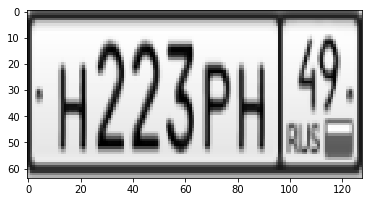

2) the_labels (plate number): H223PH49 is encoded as [14, 2, 2, 3, 18, 14, 4, 9]
3) input_length (width of image that is fed to the loss function): 30 == 128 / 4 - 2
4) label_length (length of plate number): 8


In [128]:

inp, out = next(tiger.next_batch())
print(f"Batch size: {len(inp)}")
print(f"Batch inp type: {type(inp)}")
print('Text generator output (data which will be fed into the neutral network):')
print('1) the_input (image)')
if tf.keras.backend.image_data_format() == 'channels_first':
    img = inp['the_input'][0, 0, :, :]
else:
    img = inp['the_input'][0, :, :, 0]

plt.imshow(img.T, cmap='gray')
plt.show()
print('2) the_labels (plate number): %s is encoded as %s' % 
      (labels_to_text(inp['the_labels'][0]), list(map(int, inp['the_labels'][0]))))
print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
      (inp['input_length'][0], tiger.img_w))
print('4) label_length (length of plate number): %d' % inp['label_length'][0])

In [129]:
# (batch_size, img_w, img_h, channels)
inp['the_input'].shape

(8, 128, 64, 1)

In [130]:
inp['the_labels'][0]
labels_to_text(inp['the_labels'][0]), list(map(int, inp['the_labels'][0]))

('H223PH49', [14, 2, 2, 3, 18, 14, 4, 9])

In [131]:
len(out)

1

In [132]:
out

{'ctc': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [133]:
out['ctc'].shape

(8,)

### Loss and train functions, network architecture

In [139]:
# from keras.models import Model, load_model

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


def train(img_w, load=False):
    # Input Parameters
    img_h = 64

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512

    if tf.keras.backend.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        
    batch_size = 32
    downsample_factor = pool_size ** 2
    tiger_train = TextImageGenerator('/home/martin/workspace/datasets/ocr-2213/train/anpr_ocr/train/', img_w, img_h, batch_size, downsample_factor)
    tiger_train.build_data()
    tiger_val = TextImageGenerator('/home/martin/workspace/datasets/ocr-2213/val/anpr_ocr/train', img_w, img_h, batch_size, downsample_factor)
    tiger_val.build_data()

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # 
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, (1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    if load:
        model = load_model('./tmp_model.h5', compile=False)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if not load:
        # captures output of softmax so we can decode the output during visualization
        test_func = tf.keras.backend.function([input_data], [y_pred])

        model.fit_generator(generator=tiger_train.next_batch(), 
                            steps_per_epoch=tiger_train.n,
                            epochs=1, 
                            validation_data=tiger_val.next_batch(), 
                            validation_steps=tiger_val.n)

    return model

### Model description and training

In [ ]:
model = train(128, load=False)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 128, 64, 1)    0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 128, 64, 16)   160         the_input[0][0]                  
____________________________________________________________________________________________________
max1 (MaxPooling2D)              (None, 64, 32, 16)    0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Conv2D)                   (None, 64, 32, 16)    2320        max1[0][0]                       
___________________________________________________________________________________________

In [62]:
tensorflow.python.keras.backend

NameError: name 'tensorflow' is not defined

In [63]:
tf.keras.backend

<module 'tensorflow.python.keras.backend' from '/home/martin/anaconda3/envs/dlf/lib/python3.6/site-packages/tensorflow/python/keras/backend/__init__.py'>

In [64]:
tensorflow.python.keras.backend

NameError: name 'tensorflow' is not defined